In [1]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [3]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('../Data/gtd_eda_1996to2017.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### Inspect the Structure
The cleansed data frame contains 48 attributes, one of which is used for the data frame index, and 119153 observations.

In [4]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119153 entries, 199601000001 to 201712310032
Data columns (total 48 columns):
iyear               119153 non-null int64
imonth              119153 non-null int64
iday                119153 non-null int64
country_txt         119153 non-null object
region_txt          119153 non-null object
provstate           119153 non-null object
city                119153 non-null object
latitude            119153 non-null float64
longitude           119153 non-null float64
specificity         119153 non-null float64
summary             119153 non-null object
attacktype1_txt     119153 non-null object
targtype1_txt       119153 non-null object
targsubtype1_txt    119153 non-null object
corp1               119153 non-null object
target1             119153 non-null object
natlty1_txt         119153 non-null object
gname               119153 non-null object
nperpcap            119153 non-null float64
weaptype1_txt       119153 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [5]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for single data type
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119153 entries, 199601000001 to 201712310032
Data columns (total 48 columns):
iyear               119153 non-null int64
imonth              119153 non-null int64
iday                119153 non-null int64
country_txt         119153 non-null category
region_txt          119153 non-null category
provstate           119153 non-null object
city                119153 non-null object
latitude            119153 non-null float64
longitude           119153 non-null float64
specificity         119153 non-null category
summary             119153 non-null object
attacktype1_txt     119153 non-null category
targtype1_txt       119153 non-null category
targsubtype1_txt    119153 non-null category
corp1               119153 non-null object
target1             119153 non-null object
natlty1_txt         119153 non-null category
gname               119153 non-null object
nperpcap            119153 non-null float64
weaptype1_txt       119153 non-null categ

### Drop Text Attributes
Remove the text attributes, which will not be used in the models.

In [132]:
# # gtd_df = gtd_df.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
# #                                   'scite1', 'dbsource'], axis=1)
# gtd_df.info(verbose = True)

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [7]:
scaler = preprocessing.StandardScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Normalize the attributes in place
gtd_df[scale_attrs] = scaler.fit_transform(gtd_df[scale_attrs])

# View the transformation
gtd_df[scale_attrs].describe().transpose()

count          mean       std       min       25%       50%  \
nperpcap  119153.0  1.899435e-14  1.000004 -0.056051 -0.056051 -0.056051   
nkill     119153.0 -7.780110e-15  1.000004 -0.206442 -0.206442 -0.123647   
nkillus   119153.0 -5.374686e-15  1.000004 -0.006380 -0.006380 -0.006380   
nkillter  119153.0  7.330076e-14  1.000004 -0.115497 -0.115497 -0.115497   
nwound    119153.0 -2.807015e-14  1.000004 -0.091419 -0.091419 -0.091419   
nwoundus  119153.0 -5.274322e-15  1.000004 -0.020851 -0.020851 -0.020851   
nwoundte  119153.0 -6.958628e-14  1.000004 -0.068800 -0.068800 -0.068800   

               75%         max  
nperpcap -0.056051  206.050467  
nkill    -0.040853  129.780906  
nkillus  -0.006380  245.505760  
nkillter -0.115497  121.962325  
nwound   -0.039418  212.878054  
nwoundus -0.020851  185.056424  
nwoundte -0.068800  138.312406

In [8]:
country.value_counts()

Iraq                                24396
Pakistan                            12978
Afghanistan                         12537
India                                9469
Philippines                          5070
Somalia                              3995
Nigeria                              3837
Thailand                             3640
Yemen                                3216
Colombia                             3148
Libya                                2212
Russia                               2087
Egypt                                2069
Syria                                2027
Turkey                               2006
Algeria                              1990
Ukraine                              1688
West Bank and Gaza Strip             1359
United Kingdom                       1312
Bangladesh                           1238
Israel                               1208
Nepal                                1186
Sri Lanka                            1157
France                            

### Iraq
Subset the data to the last 10 year of events in Iraq.

In [90]:
del [[iraq_df,iraq_counts,idx,iraq_ts,iraq_fb]]
gc.collect()

203

In [91]:
iraq_df = gtd_df[gtd_df['country_txt'] == "Iraq"].query('2006<iyear<=2017')

iraq_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22506 entries, 200701040002 to 201712310012
Data columns (total 41 columns):
iyear               22506 non-null int64
imonth              22506 non-null int64
iday                22506 non-null int64
country_txt         22506 non-null category
region_txt          22506 non-null category
latitude            22506 non-null float64
longitude           22506 non-null float64
specificity         22506 non-null category
attacktype1_txt     22506 non-null category
targtype1_txt       22506 non-null category
targsubtype1_txt    22506 non-null category
natlty1_txt         22506 non-null category
gname               22506 non-null object
nperpcap            22506 non-null float64
weaptype1_txt       22506 non-null category
weapsubtype1_txt    22506 non-null category
nkill               22506 non-null float64
nkillus             22506 non-null float64
nkillter            22506 non-null float64
nwound              22506 non-null float64
nwoundus   

### Attacks per Day
Calculate the number of attacks per day.

In [92]:
# Group by incident_date
iraq_counts = iraq_df.groupby(['incident_date'], as_index = False).count()

# Select incident_date and a column for the counts
iraq_counts = iraq_counts[['incident_date', 'iyear']]
iraq_counts.columns = ['incident_date','daily_attacks']
iraq_counts.tail()

incident_date  daily_attacks
3656    2017-12-27              5
3657    2017-12-28              5
3658    2017-12-29              6
3659    2017-12-30              4
3660    2017-12-31              6

### Reindex and Fill
Reindex the dataframe to include all days for the 10 year period and fill added days with zero.

In [93]:
idx = pd.date_range('2007-01-01', '2017-12-31')

iraq_ts = iraq_counts.set_index('incident_date')

iraq_ts = iraq_ts.reindex(idx, fill_value=0)
iraq_ts.head()

daily_attacks
2007-01-01              0
2007-01-02              0
2007-01-03              0
2007-01-04              1
2007-01-05              1

### Summary Statistics
Display summary statistics on the time series dataframe.

In [94]:
iraq_ts.describe()

daily_attacks
count    4018.000000
mean        5.601294
std         5.677133
min         0.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       108.000000

### Daily Plot - Total Attacks

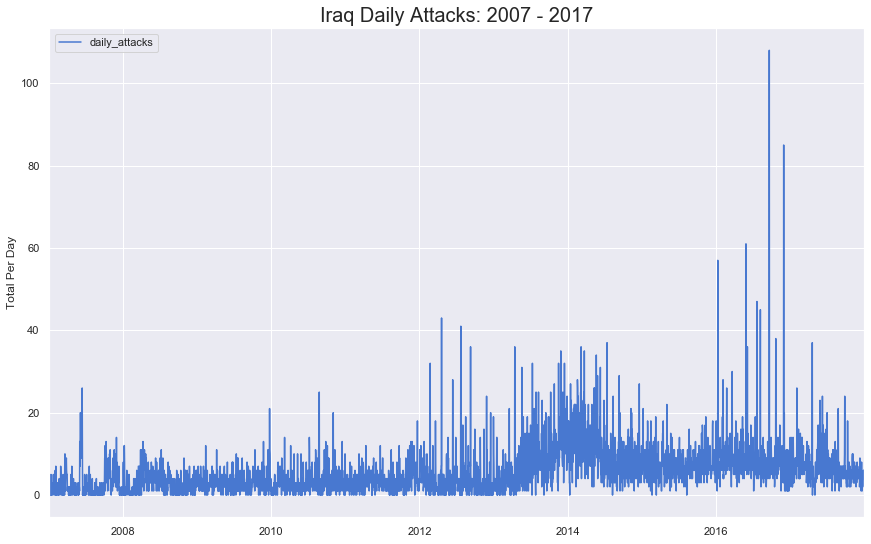

In [109]:
pd.plotting.register_matplotlib_converters()
iraq_ts.plot()
plt.title('Iraq Daily Attacks: 2007 - 2017', fontsize=20);
plt.ylabel('Total Per Day')
plt.show();

### Weekly Plot - Average Attacks
Weekly average using the resampled daily data.

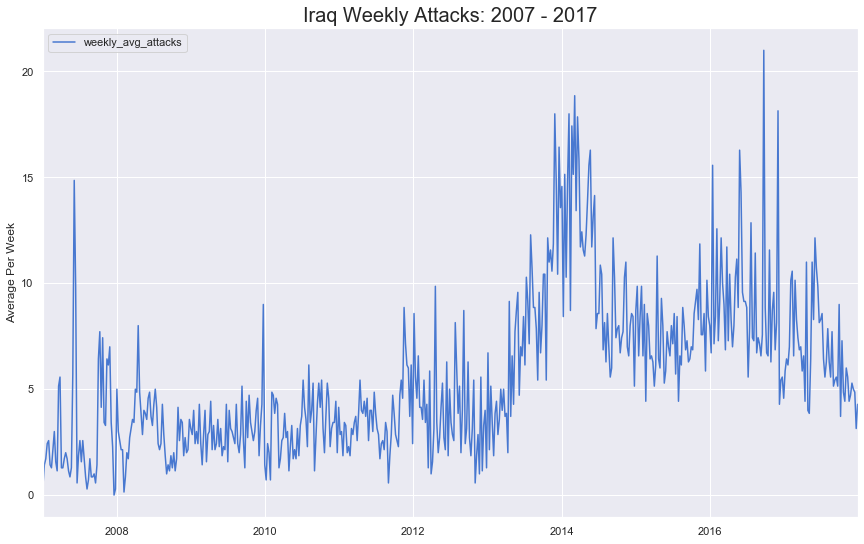

In [110]:
weekly_summary = pd.DataFrame()
weekly_summary['weekly_avg_attacks'] = iraq_ts.daily_attacks.resample('W').mean()

weekly_summary.plot()
plt.title('Iraq Weekly Attacks: 2007 - 2017', fontsize=20);
plt.ylabel('Average Per Week')
plt.show();

### Monthly Plot - Average Attacks
Monthly average using the resampled daily data.

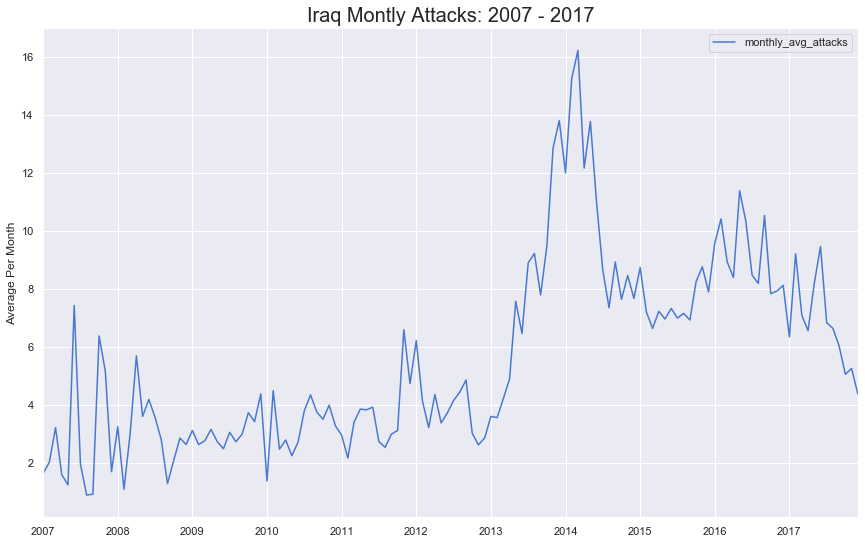

In [111]:
monthly_summary = pd.DataFrame()
monthly_summary['monthly_avg_attacks'] = iraq_ts.daily_attacks.resample('M').mean()

monthly_summary.plot()
plt.title('Iraq Montly Attacks: 2007 - 2017', fontsize=20);
plt.ylabel('Average Per Month')
plt.show();

### Exponential Weighted Moving Average
Apply smoothing using exponential weighted moving average.

In [98]:
# Use a 30 day span for averaging
iraq_ewm = iraq_ts.ewm(span=30, adjust=False).mean()

iraq_ewm.head()

daily_attacks
2007-01-01       0.000000
2007-01-02       0.000000
2007-01-03       0.000000
2007-01-04       0.064516
2007-01-05       0.124870

### Exponential Weighted Moving Average
Daily attacks in Iraq, 2007 to 2017.

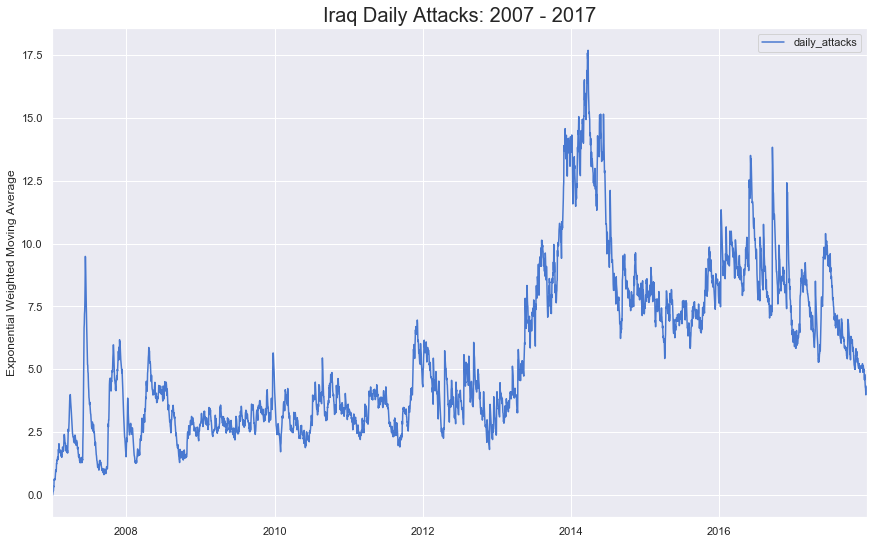

In [112]:
iraq_ewm.plot()
plt.title('Iraq Daily Attacks: 2007 - 2017', fontsize=20);
plt.ylabel('Exponential Weighted Moving Average')
plt.show();

### Facebook Prophet
Create a modified dataset to comply with the Facebook Prophet requirements.

In [100]:
import fbprophet
from fbprophet import Prophet
iraq_fb = iraq_ts.copy()
iraq_fb['index1'] = iraq_fb.index
iraq_fb.columns = ['y', 'ds']

iraq_fb.head()

y         ds
2007-01-01  0 2007-01-01
2007-01-02  0 2007-01-02
2007-01-03  0 2007-01-03
2007-01-04  1 2007-01-04
2007-01-05  1 2007-01-05

### Iraq Holidays
Iraq regional and national holidays covering 2007 - 2017.

In [83]:
# # Load the preprocessed GTD dataset
iraq_holidays = pd.read_csv('../Data/iraq-holidays.csv',na_values=[''])
iraq_holidays.head()

Date        Day          Festival
0  01/01/07     Monday      New Year Day
1  06/01/07   Saturday          Army Day
2  19/01/07     Friday  Islamic New Year
3  28/01/07     Sunday            Ashura
4  21/03/07  Wednesday  Persian New Year

In [84]:
iraq_holidays.rename(columns={"Date":"ds","Festival":"holiday"},inplace=True)

In [86]:
iraq_holidays.drop('Day',axis=1,inplace=True)

In [88]:
iraq_holidays.tail()

ds                         holiday
140  21/09/17                Islamic New Year
141  01/10/17                          Ashura
142  03/10/17                    National Day
143  01/12/17  Mouloud (Birth of the Prophet)
144  31/12/17                        Iraq Day

In [89]:
iraq_holidays['ds'].dtypes

dtype('O')

### Time Series Model
Create the time serie model for attacks in Iraq and factor in Iraq holidays.

In [134]:
# Make the prophet model and fit on the data
iqprophet = fbprophet.Prophet(changepoint_prior_scale=0.15,holidays_prior_scale=20, holidays=iraq_holidays,daily_seasonality=True)
iqprophet.fit(iraq_fb)

### Predict 1 Year of Future Dates
Predict 365 days after last the data point of 2017-12-31.

In [135]:
# Specify 365 days out to predict
future_data = iqprophet.make_future_dataframe(periods=365, freq = 'D')

# Predict the values
forecast_data = iqprophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds      yhat  yhat_lower  yhat_upper
4373 2018-12-22  3.942762   -2.842672   10.800658
4374 2018-12-23  4.870986   -1.839887   11.827248
4375 2018-12-24  4.855034   -1.818426   11.863000
4376 2018-12-25  4.518996   -1.827607   11.106557
4377 2018-12-26  5.023364   -1.973873   11.667741
4378 2018-12-27  4.683032   -1.910710   11.053645
4379 2018-12-28  3.031612   -3.583681    9.818856
4380 2018-12-29  4.043228   -2.444450   11.466563
4381 2018-12-30  5.007642   -2.045409   12.521913
4382 2018-12-31  5.021829   -1.746341   11.989532

In [136]:
forecast_data.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2007-01-01  0.419021   -4.018205    8.574917     0.419021     0.419021   
1 2007-01-02  0.423192   -3.833850    7.559710     0.423192     0.423192   
2 2007-01-03  0.427362   -3.824295    8.676806     0.427362     0.427362   
3 2007-01-04  0.431533   -3.917632    7.758833     0.431533     0.431533   
4 2007-01-05  0.435704   -4.827116    7.430667     0.435704     0.435704   

   Army Day  Army Day_lower  Army Day_upper  Ashura  Ashura_lower  \
0       0.0             0.0             0.0     0.0           0.0   
1       0.0             0.0             0.0     0.0           0.0   
2       0.0             0.0             0.0     0.0           0.0   
3       0.0             0.0             0.0     0.0           0.0   
4       0.0             0.0             0.0     0.0           0.0   

   Ashura_upper  Baghdad Liberation Day  Baghdad Liberation Day_lower  \
0           0.0                     0.0                           0.0   
1           0.0                     0.0                           0.0   
2           0.0                     0.0                           0.0   
3           0.0                     0.0                           0.0   
4           0.0                     0.0                           0.0   

   Baghdad Liberation Day_upper  Eid al-Adha (Feast of Sacrifice)  \
0                           0.0                               0.0   
1                           0.0                               0.0   
2                           0.0                               0.0   
3                           0.0                               0.0   
4                           0.0                               0.0   

   Eid al-Adha (Feast of Sacrifice)_lower  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Eid al-Adha (Feast of Sacrifice)_upper  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Eid al-Adha (Feast of the Sacrifice)  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   Eid al-Adha (Feast of the Sacrifice)_lower  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Eid al-Adha (Feast of the Sacrifice)_upper  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Eid al-Adha(Feast of Sacrifice)  Eid al-Adha(Feast of Sacrifice)_lower  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              0.0                                    0.0   
4                              0.0                                    0.0   

   Eid al-Adha(Feast of Sacrifice)_upper  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   Eid ul-Fitr or Id-Ul-Fitr (End of Ramadan)  \
0                                         0.0   
1                                         0.0   
2                 

### Plot the Predictions

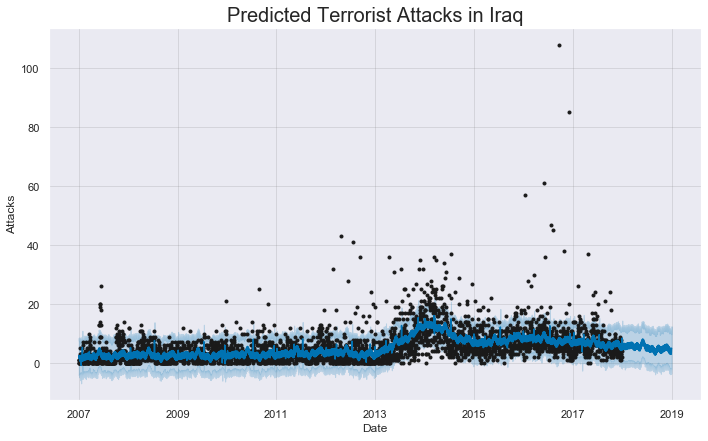

In [137]:
iqprophet.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.show();

### Examine Seasonality and Trend Components
The spike in June occurs before Eid ul-Fitr or Id-Ul-Fitr (End of Ramadan), and the jump in December follows the Mouloud (Birth of the Prophet).  The drop in September occurs near the Eid al-Adha (Feast of the Sacrifice) and the Islamic New Year. The low number of attacks on Friday corresponds to Muslims Friday prayer.

Since Prophet uses an additive model, the y-axis represents the absolute change relative to the trend (Letham, 2018).

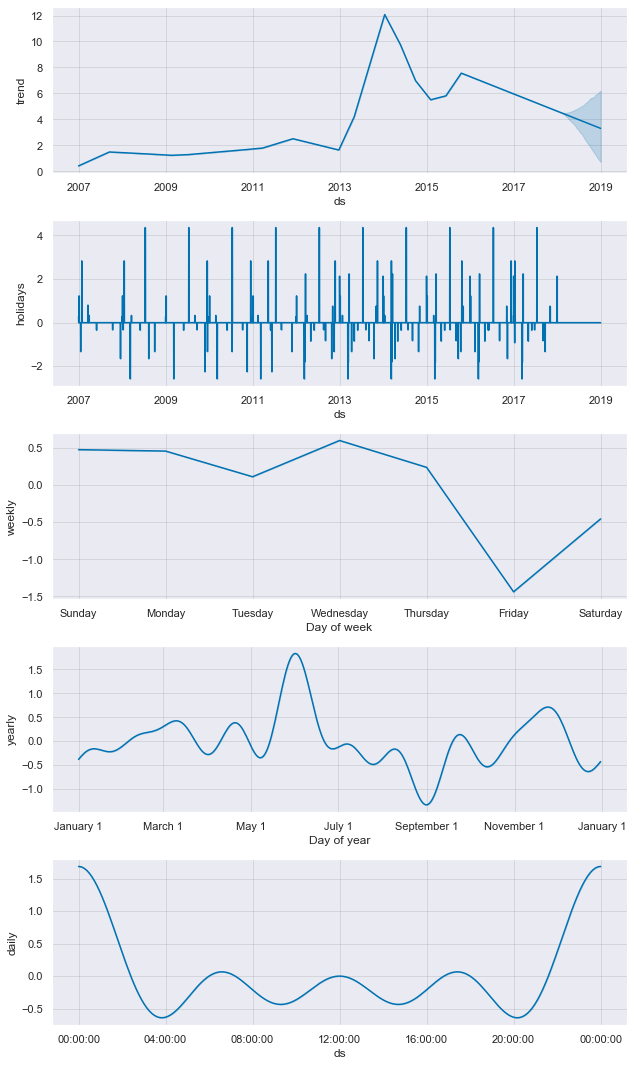

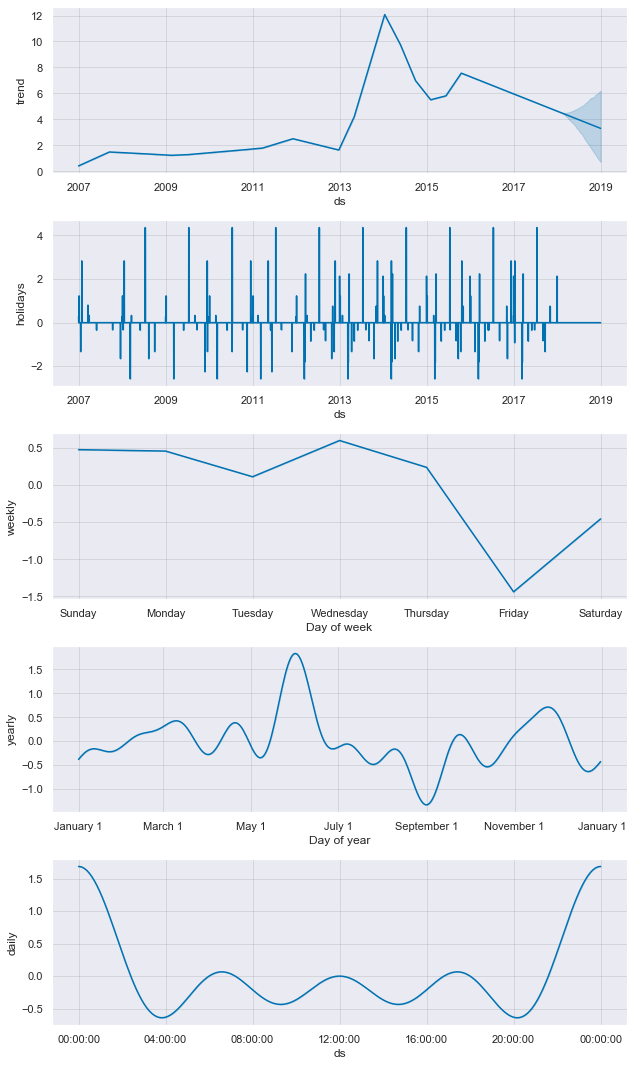

In [138]:
iqprophet.plot_components(forecast_data)

### Zoom in to the Last Year Plus One Year of Predictions
The forecasted trend seems to align with the yearly seasonality shown in the component analysis.

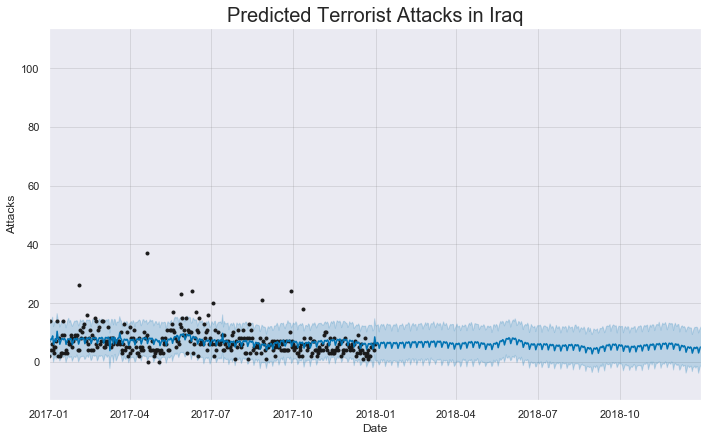

In [128]:
iqprophet.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2018-12-31'))
plt.show();

In [129]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(iqprophet, forecast_data)  # This returns a plotly Figure
fig

In [130]:
print("Observed Value:",int(forecast_data.trend.sum()), "Forecasting Value:",int(forecast_data.yhat.sum()), 
      "Forecasting Lower Bound:",int(forecast_data.yhat_lower.sum()),"Forecasting Upper Bound:",int(forecast_data.yhat_upper.sum()))

Observed Value: 17324 Forecasting Value: 24574 Forecasting Lower Bound: -2069 Forecasting Upper Bound: 51221


In [139]:
# from fbprophet.diagnostics import cross_validation
# def mean_absolute_percentage_error(y_true,y_pred):
#     y_true,y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [ ]:
cv_results = cross_validation(iqprophet,horizon = '5 days')

INFO:fbprophet:Making 1459 forecasts with cutoffs between 2008-01-03 00:00:00 and 2017-12-26 00:00:00


In [ ]:
mape_baseline = mean_absolute_percentage_error(cv_results.y,cv_results.yhat)
mape_baseline

### References

Prophet Quick Start Retrieved from https://facebook.github.io/prophet/docs/quick_start.html

Brown, E. (2017). Forecasting time-series data with Prophet – Part 1. Retrieved from http://pythondata.com/forecasting-time-series-data-with-prophet-part-1/

Lyla, Y. (2019) A Quick Start of Time Series Forecasting with a Practical Example using FB Prophet Retrieved from https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274

Pandas Query Documentation. Retrieved from
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html

Facebook Open Source. (n.d.). Seasonality and holiday effects. Retrieved from https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

Holidayyear. (2018). Iraqi public holidays. Retrieved from http://holidayyear.com/holidays/Iraq/

Letham, B. (2018). Meaning of y-axis in component plot. Retrieved from https://github.com/facebook/prophet/issues/422

Plotting Pandas Time Series Data in Prophet Retrieved from https://nextjournal.com/blog/plotting-pandas-prophet